In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pycocotools.coco import COCO
import os
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf

img_dir = "/content/drive/MyDrive/RSNA_BONE_AGE/project-1-at-2022-10-05-11-06-ccb01c3f/images"
annFile = "/content/drive/MyDrive/RSNA_BONE_AGE/project-1-at-2022-10-05-11-06-ccb01c3f/result.json"

coco=COCO(annFile)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [ ]:
# Get annotation IDs
annsIds = coco.getAnnIds()

In [ ]:
!mkdir output

In [ ]:
output_dir = "./output"

masks = []
for ann in annsIds:
    # Get individual masks
    mask = coco.annToMask(coco.loadAnns(ann)[0])
    file_name = coco.loadImgs(coco.loadAnns(ann)[0]['image_id'])[0]['file_name'][9:]
    tf.keras.utils.save_img(
        f"{output_dir}/{file_name}",
        tf.expand_dims(mask,axis=-1),
        scale=False,
    )

In [ ]:
X = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    image_size=(256,256),
    labels=None,
    shuffle=False,
    batch_size=None,
    color_mode="grayscale"
)

Found 30 files belonging to 1 classes.


In [ ]:
y = tf.keras.utils.image_dataset_from_directory(
    output_dir,
    image_size=(256,256),
    labels=None,
    shuffle=False,
    batch_size=None,
    color_mode="grayscale"    
)

Found 30 files belonging to 1 classes.


In [ ]:
temp_arr = list(X.as_numpy_iterator())
masks = list(y.as_numpy_iterator())

for i in range(0,30):

  masks.append(tf.image.stateless_random_flip_left_right(masks[i],(2,3)))
  masks.append(tf.image.stateless_random_flip_up_down(masks[i],(2,3)))
  temp_arr.append(tf.image.stateless_random_flip_left_right(temp_arr[i],(2,3)))
  temp_arr.append(tf.image.stateless_random_flip_up_down(temp_arr[i],(2,3)))

  

dataset = tf.data.Dataset.from_tensor_slices(
    (
        temp_arr,
        masks
    )
)
dataset = dataset.shuffle(10)

In [ ]:
len(dataset)

90

In [ ]:
train_datagen = dataset.take(70).batch(10)
remaining = dataset.skip(70)
test_datagen = remaining.take(20).batch(10)

In [ ]:
# Building an unet model
from tensorflow.keras.layers import Conv2D,Dropout,Conv2DTranspose,concatenate,Input,MaxPooling2D

tf.random.set_seed(42)

def build_model(start_neurons):

    input_layer = Input(shape=(256,256,1))

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    # uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    # uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    # uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    # uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (2,2), padding="same", activation="sigmoid")(uconv1)

    
    model = tf.keras.Model(inputs=[input_layer],outputs=[output_layer])

    return model

model = build_model(10)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 10  100         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 10  910         ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
checkpoint_filepath = "temp"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

In [ ]:
model.fit(
    train_datagen,
    validation_data=test_datagen,
    epochs=100,
    validation_steps=len(test_datagen),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
7/7 [==============================] - 13s 141ms/step - loss: 0.7379 - accuracy: 0.3865 - val_loss: 0.6658 - val_accuracy: 0.4544
Epoch 2/100
7/7 [==============================] - 1s 119ms/step - loss: 0.6928 - accuracy: 0.4136 - val_loss: 0.6625 - val_accuracy: 0.5017
Epoch 3/100
7/7 [==============================] - 0s 71ms/step - loss: 0.6797 - accuracy: 0.4316 - val_loss: 0.6521 - val_accuracy: 0.4989
Epoch 4/100
7/7 [==============================] - 0s 73ms/step - loss: 0.6657 - accuracy: 0.4385 - val_loss: 0.6385 - val_accuracy: 0.4978
Epoch 5/100
7/7 [==============================] - 1s 87ms/step - loss: 0.6506 - accuracy: 0.4637 - val_loss: 0.6194 - val_accuracy: 0.5559
Epoch 6/100
7/7 [==============================] - 1s 85ms/step - loss: 0.6300 - accuracy: 0.5775 - val_loss: 0.5874 - val_accuracy: 0.6959
Epoch 7/100
7/7 [==============================] - 1s 89ms/step - loss: 0.5879 - accuracy: 0.6728 - val_loss: 0.5280 - val_accuracy: 0.7387
Epoch 8/100
7/7 [

In [ ]:
model.evaluate(test_datagen)

2/2 [==============================] - 0s 39ms/step - loss: 0.0482 - accuracy: 0.9814


[0.0482214018702507, 0.9813926815986633]

In [ ]:
def predict_mask(img):
  return tf.round(model.predict(tf.expand_dims(img,axis=0))[0])

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
model.evaluate(test_datagen)

2/2 [==============================] - 0s 39ms/step - loss: 0.0317 - accuracy: 0.9859


[0.031654201447963715, 0.9859153628349304]

In [ ]:
model.save('unet.h5')

In [ ]:
from google.colab import files

files.download('unet.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Testing an unknown image

path = '/content/drive/MyDrive/RSNA_BONE_AGE/10010.png'

img = tf.keras.utils.load_img(
    path,
    target_size=(256,256),
    color_mode='grayscale'
)
img_arr = tf.keras.preprocessing.image.img_to_array(img)

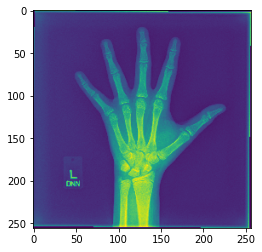

In [ ]:
plt.imshow(tf.squeeze(img_arr))

In [ ]:
plt.imshow(tf.squeeze(predict_mask(img_arr)*img_arr),cmap="gray")

NameError: ignored

# Semantic segmentation ends able to acheive 99% accuracy

In [ ]:
import tensorflow as tf

unet_model_path = '/content/drive/MyDrive/RSNA_BONE_AGE/unet.h5'
unet_model = tf.keras.models.load_model(unet_model_path)

In [ ]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 10  100         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 10  910         ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
# Using CNN for classification and regression
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

KeyboardInterrupt: ignored

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

In [ ]:
!unzip "rsna-bone-age.zip"

Streaming output truncated to the last 5000 lines.
  inflating: boneage-training-dataset/boneage-training-dataset/4264.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4265.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4266.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4268.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4269.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4270.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4271.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4272.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4273.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4275.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4276.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4277.png  
  inflating: boneage-training-dataset/boneage-training-datase

In [ ]:
training_reg_dataset_image_path = '/content/boneage-training-dataset/boneage-training-dataset'
training_dataset_csv = '/content/boneage-training-dataset.csv'

In [ ]:
import os
import tensorflow as tf

for root,dir,files in os.walk(training_reg_dataset_image_path):
  print(f"{root} has {len(files)} images here")

/content/boneage-training-dataset/boneage-training-dataset has 12611 images here


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_dataset = pd.read_csv(training_dataset_csv)
train_dataset.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12611 entries, 0 to 12610
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   id       12611 non-null  int64
 1   boneage  12611 non-null  int64
 2   male     12611 non-null  bool 
dtypes: bool(1), int64(2)
memory usage: 209.5 KB


## This dataset does not have any null values

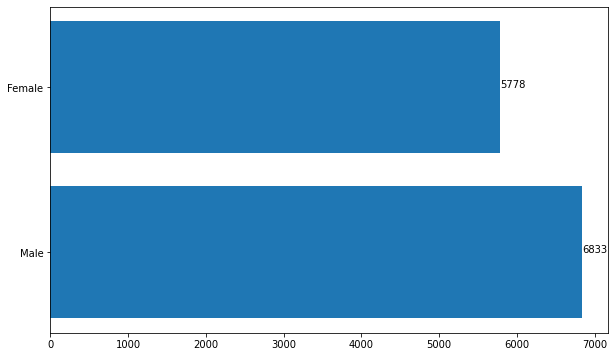

In [ ]:
fig = plt.figure(figsize=(10,6))

data = train_dataset['male'].value_counts()

def gen_func(gen):
  if gen: return "Male"
  return "Female"

x = list(data.keys().map(gen_func))
y = list(data.values)

plt.barh(x,y)

for index,val in enumerate(y):
  plt.text(val,index,val)

plt.show()

# This data is an evenly distributed data set on basis of gender

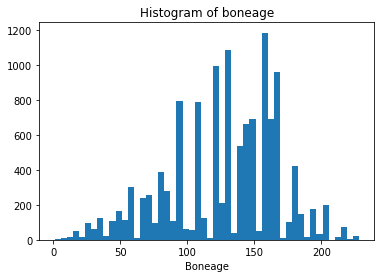

In [ ]:
plt.hist(train_dataset["boneage"],50)
plt.title("Histogram of boneage")
plt.xlabel("Boneage")
plt.show()

In [ ]:
y_age = train_dataset['boneage']

In [ ]:
X_train_image = tf.keras.utils.image_dataset_from_directory(
    training_reg_dataset_image_path,
    shuffle=False,
    image_size=(256,256),
    color_mode='grayscale',
    batch_size=None,
    labels=None
)

Found 12611 files belonging to 1 classes.


In [ ]:
def segment_image_mapper(img):
   mask = tf.math.round(unet_model(tf.expand_dims(img,axis=0)))
   img = tf.image.grayscale_to_rgb(img*mask)
   return tf.squeeze(img)

In [ ]:
X_train_image = X_train_image.map(segment_image_mapper)

In [ ]:
X_img_arr = list(X_train_image.take(2000).as_numpy_iterator())

In [ ]:
age_arr = list(y_age[:2000])

In [ ]:
len_img_arr = len(X_img_arr)

for i in range(len_img_arr):
  X_img_arr.append(tf.image.stateless_random_flip_left_right(X_img_arr[i],(2,3)))
  X_img_arr.append(tf.image.stateless_random_flip_up_down(X_img_arr[i],(2,3)))
  age_arr.extend([age_arr[i]]*2)

In [ ]:
train_datagen_reg = tf.data.Dataset.from_tensor_slices((X_img_arr,age_arr))

In [ ]:
len(train_datagen_reg)

6000

In [ ]:
train_reg_datagen = train_datagen_reg.take(5000).batch(32)
test_reg_datagen = train_datagen_reg.skip(5000).batch(32)

In [ ]:
base_model = tf.keras.applications.xception.Xception(
    include_top=False
)

base_model.trainable = True

In [ ]:
def create_reg_model():

  tf.random.set_seed(42)

  data_augmentation = tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255)
  ])

  input = tf.keras.Input(shape=(256,256,3))
  x = base_model(data_augmentation(input), training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1000, activation="relu")(x)
  x = tf.keras.layers.Dense(500, activation="relu")(x)
  x = tf.keras.layers.Dense(256, activation="relu")(x)
  x = tf.keras.layers.Dense(128, activation="relu")(x)
  x = tf.keras.layers.Dense(64, activation="relu")(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  output = tf.keras.layers.Dense(1)(x)

  model = tf.keras.Model(inputs=input,outputs=output)

  return model

In [ ]:
model_reg = create_reg_model()

In [ ]:
model_reg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                             

In [ ]:
model_reg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
train_reg_datagen = train_reg_datagen.shuffle(32)

In [ ]:
checkpoint_filepath_reg = "temp_reg"
model_checkpoint_callback_reg = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_reg,
    save_weights_only=True,
    monitor="val_mean_absolute_error",
    mode="min",
    save_best_only=True
)

In [ ]:
model_reg.fit(
  train_reg_datagen,
  validation_data=test_reg_datagen,
  validation_steps=len(test_reg_datagen),
  epochs=10,
  callbacks=[model_checkpoint_callback_reg]
)

In [ ]:
model_reg.evaluate(test_reg_datagen)

In [ ]:
model_reg.load_weights(checkpoint_filepath_reg)

In [ ]:
model_reg.evaluate(test_reg_datagen)

7/7 [==============================] - 3s 262ms/step - loss: 34.6878 - mean_absolute_error: 34.6878


[34.687782287597656, 34.687782287597656]